In [25]:

%pip install duckdb
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install groq
%pip install langchain-openai
%pip install langchain-community
%pip install typing-extensions
%pip install ipython


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached langchain_anthropic-0.2.3-py3-none-any.whl.metadata (2.3 kB)
  Using cached anthropic-0.36.2-py3-none-any.whl.metadata (21 kB)
  Using cached defusedxml-0.7.1-py2.py3-none-any.whl.metadata (32 kB)
  Using cached tokenizers-0.20.1.tar.gz (339 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Checking for Rust toolchain....
      
      Cargo,


Resultados da consulta:
('Produto C', 1)
('Produto B', 1)
('Produto A', 2)

Interpretação dos resultados:
**Interpretação dos resultados da consulta**

A consulta foi executada com o objetivo de identificar a distribuição de produtos entre os clientes que pagam acima da média geral. Os resultados mostram a quantidade (qtd) de clientes que pagaram acima da média geral para cada produto.

**Resposta à pergunta original**

Os resultados da consulta indicam que:

* Os clientes que pagaram acima da média geral compraram principalmente produtos A (2 vezes) e B (1 vez) e C (1 vez).
* Os produtos A e B foram comprados apenas uma vez cada, enquanto o produto C foi comprado apenas uma vez.

**Sugestão de gráfico adequado**

Considerando os dados numéricos, uma boa escolha para visualizar a distribuição de produtos entre os clientes que pagam acima da média geral seria um **Grafo de Barras**. Esse tipo de gráfico é adequado para comparar as quantidades de produto comprado pelos clientes que paga


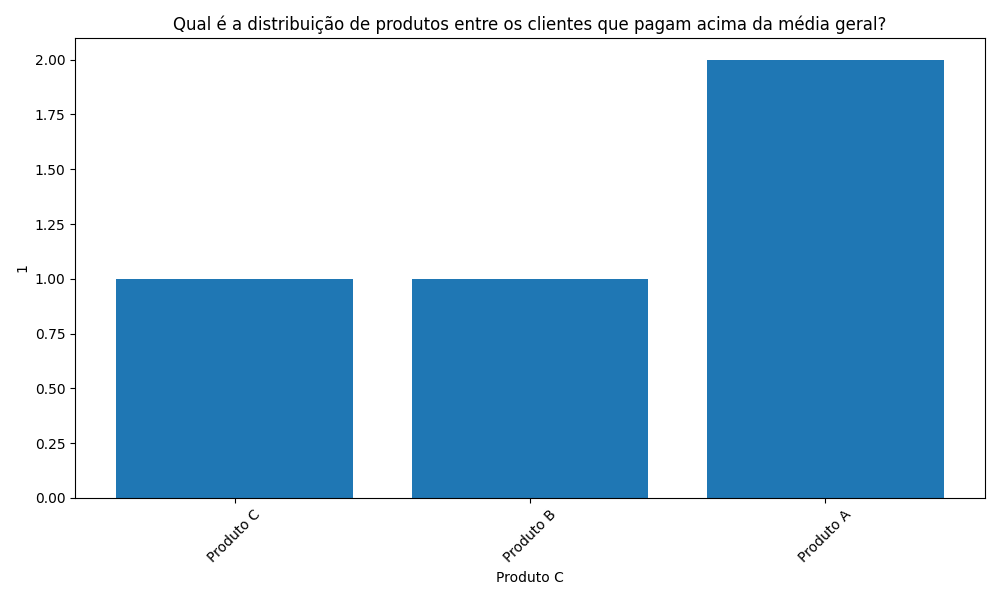

In [26]:
import warnings
warnings.filterwarnings('ignore')

import duckdb
import numpy as np
import pandas as pd
import os
from typing_extensions import TypedDict
from typing import List, Annotated
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
import io
import base64

# Importações para diferentes modelos
from groq import Groq
from langchain_openai import ChatOpenAI

# Configuração do modelo
MODEL_TYPE = "groq"  # Opções: "groq" ou "openai"

if MODEL_TYPE == "groq":
    client = Groq(api_key="Coloque seu API KEY aqui")
    model = "llama-3.1-8b-instant"
elif MODEL_TYPE == "openai":
    os.environ['OPENAI_API_KEY'] = 'sua_chave_api_openai_aqui'
    model = ChatOpenAI(model_name="gpt-4", temperature=0)

# Função para invocar o modelo
def invoke_model(messages):
    if MODEL_TYPE == "groq":
        chat_completion = client.chat.completions.create(
            messages=messages,
            model=model,
        )
        return chat_completion.choices[0].message.content
    else:
        return model.invoke(messages).content

# Definir o estado do agente
class AgentState(TypedDict):
    question: str
    table_schemas: str
    database: str
    sql: str
    reflect: List[str]
    accepted: bool
    revision: int
    max_revision: int

# Função para obter o esquema do banco de dados
def get_database_schema(db_path):
    conn = duckdb.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT table_name FROM information_schema.tables WHERE table_schema='main'")
    tables = cursor.fetchall()
    schema = ''
    for table_name in tables:
        table_name = table_name[0]
        cursor.execute(f"DESCRIBE {table_name}")
        columns = cursor.fetchall()
        schema += f"Table: {table_name}\n"
        schema += "Columns:\n"
        for column in columns:
            schema += f" - {column[0]} ({column[1]})\n"
        schema += '\n'
    conn.close()
    return schema

# Obter o esquema do banco de dados
db_schema = get_database_schema('clientes_novo.duckdb')

# Função do Search Engineer
def search_engineer_node(state: AgentState):
    return {**state, "table_schemas": db_schema, "database": 'clientes_novo.duckdb'}

# Função do SQL Writer
def senior_sql_writer_node(state: AgentState):
    role_prompt = """
Você é um especialista em SQL. Sua tarefa é escrever **apenas** a consulta SQL que responda à pergunta do usuário. A consulta deve:

- Usar a sintaxe SQL padrão em inglês.
- Utilizar os nomes das tabelas e colunas conforme definidos no esquema do banco de dados.
- Não incluir comentários, explicações ou qualquer texto adicional.
- Não utilizar formatação de código ou markdown.
- Retornar apenas a consulta SQL válida.
"""
    instruction = f"Esquema do banco de dados:\n{state['table_schemas']}\n"
    instruction += f"Escreva a consulta SQL que responda à seguinte pergunta: {state['question']}\n"
    messages = [
        {"role": "system", "content": role_prompt},
        {"role": "user", "content": instruction}
    ]
    response = invoke_model(messages)
    return {**state, "sql": response.strip(), "revision": state['revision'] + 1}

# Função do QA Engineer
def senior_qa_engineer_node(state: AgentState):
    role_prompt = """
Você é um engenheiro de QA especializado em SQL. Sua tarefa é verificar se a consulta SQL fornecida responde corretamente à pergunta do usuário.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Verifique se a consulta SQL pode completar a tarefa: {state['question']}\n"
    instruction += "Responda 'ACEITO' se estiver correta ou 'REJEITADO' se não estiver.\n"
    messages = [
        {"role": "system", "content": role_prompt},
        {"role": "user", "content": instruction}
    ]
    response = invoke_model(messages)
    return {**state, "accepted": 'ACEITO' in response.upper()}

# Função do Chief DBA
def chief_dba_node(state: AgentState):
    role_prompt = """
Você é um DBA experiente. Sua tarefa é fornecer feedback detalhado para melhorar a consulta SQL fornecida.
"""
    instruction = f"Com base no seguinte esquema de banco de dados:\n{state['table_schemas']}\n"
    instruction += f"E na seguinte consulta SQL:\n{state['sql']}\n"
    instruction += f"Por favor, forneça recomendações úteis e detalhadas para ajudar a melhorar a consulta SQL para a tarefa: {state['question']}\n"
    messages = [
        {"role": "system", "content": role_prompt},
        {"role": "user", "content": instruction}
    ]
    response = invoke_model(messages)
    return {**state, "reflect": [response]}

# Função para interpretar resultados e criar gráficos
def interpret_results(question, sql, results):
    role_prompt = """
Você é um assistente especializado em interpretar resultados de consultas SQL, explicá-los em linguagem natural e sugerir visualizações apropriadas.
Sua tarefa é analisar os resultados da consulta, fornecer uma resposta clara e concisa à pergunta original do usuário, e sugerir um tipo de gráfico adequado se houver dados numéricos para comparar.
"""
    instruction = f"Pergunta original: {question}\n"
    instruction += f"Consulta SQL executada: {sql}\n"
    instruction += f"Resultados da consulta: {results}\n"
    instruction += "Por favor, interprete esses resultados, responda à pergunta original em linguagem natural e sugira um tipo de gráfico adequado sempre  que aplicável, principalmente quando houver dados númericos e comparações)."

    messages = [
        {"role": "system", "content": role_prompt},
        {"role": "user", "content": instruction}
    ]
    interpretation = invoke_model(messages)

    # Verificar se há dados numéricos para plotar
    numeric_data = [row for row in results if any(isinstance(item, (int, float)) for item in row)]
    
    if len(numeric_data) > 1:
        # Criar o gráfico
        plt.figure(figsize=(10, 6))
        
        # Determinar o tipo de gráfico com base na sugestão do modelo
        if "bar" in interpretation.lower():
            plt.bar([str(row[0]) for row in numeric_data], [row[-1] for row in numeric_data])
        elif "pie" in interpretation.lower():
            plt.pie([row[-1] for row in numeric_data], labels=[str(row[0]) for row in numeric_data], autopct='%1.1f%%')
        else:  # default to line plot
            plt.plot([str(row[0]) for row in numeric_data], [row[-1] for row in numeric_data], marker='o')
        
        plt.title(question)
        plt.xlabel(results[0][0])
        plt.ylabel(results[0][-1])
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Salvar o gráfico em um buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close()
        
        # Converter o gráfico para base64
        img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
        
        # Criar HTML para exibir o gráfico
        img_html = f'<img src="data:image/png;base64,{img_base64}">'
        
        return interpretation, img_html
    else:
        return interpretation, None

# Função principal para processar a pergunta
def process_question(question):
    # Inicializar o estado
    initial_state = {
        'question': question,
        'table_schemas': '',
        'database': '',
        'sql': '',
        'reflect': [],
        'accepted': False,
        'revision': 0,
        'max_revision': 2
    }

    # Executar o fluxo de trabalho
    state = initial_state
    state = search_engineer_node(state)
    state = senior_sql_writer_node(state)
    state = senior_qa_engineer_node(state)
    
    while not state['accepted'] and state['revision'] < state['max_revision']:
        state = chief_dba_node(state)
        state = senior_sql_writer_node(state)
        state = senior_qa_engineer_node(state)

    # Conectar ao banco de dados DuckDB
    conn = duckdb.connect(state['database'])
    cursor = conn.cursor()

    try:
        cursor.execute(state['sql'])
        results = cursor.fetchall()
        print('\nResultados da consulta:')
        for result in results:
            print(result)
        
        # Interpretar os resultados e gerar gráfico, se aplicável
        interpretation, img_html = interpret_results(state['question'], state['sql'], results)
        print('\nInterpretação dos resultados:')
        print(interpretation)
        
        if img_html:
            display(HTML(img_html))
        else:
            print("Não foi possível gerar um gráfico para estes resultados.")

    except Exception as e:
        print('Erro ao executar a consulta SQL:', e)

    finally:
        cursor.close()
        conn.close()

# Exemplo de uso
question = "Qual é a distribuição de produtos entre os clientes que pagam acima da média geral?"
process_question(question)

In [27]:
question = "Quais os produtos mais vendidos?"
process_question(question)


Resultados da consulta:
('Produto B',)

Interpretação dos resultados:
Resposta à pergunta original:

Os produtos mais vendidos são os produtos cujo nome é "Produto B".

 Sugestão de gráfico: Pois os dados são discretos não há como sugerir um tipo de gráfico. Se houver os dados completos e não apenas o produto mais vendido, um barra de barras pode ser bem útil para mostrar as unidades vendidas de cada produto.
Não foi possível gerar um gráfico para estes resultados.


In [28]:
question = "Quais os produtos menos vendidos?"
process_question(question)


Resultados da consulta:
('Produto C',)
('Produto A',)
('Produto B',)

Interpretação dos resultados:
Em base nos resultados da consulta SQL que você forneceu, podemos concluir que os produtos menos vendidos são:

- **Produto C**: com a menor quantidade de vendas (ou "count" no conjunto de dados).

- **Produto A**: segue em segundo na menor quantidade de vendas em relação as vendas do Produto C.

- **Produto B**: tem uma terceira posição no conjunto de resultados com a menor quantidade de vendas.

A pergunta original permanece responder como: Os produtos menos vendidos na base de dados relacionada aos clientes fornecidos.

Sugestão de visualização: Um gráfico de barras ordenado ascendente em sua legenda ajudaria a ressaltar a quantidade de vendas do Produto C em relação aos produto B e A.
Não foi possível gerar um gráfico para estes resultados.



Resultados da consulta:
('Produto A', 3)
('Produto B', 3)
('Produto C', 2)

Interpretação dos resultados:
Resposta à perguntá original:

"Os produtos mais vendidos são o Produto A e o Produto B, ambos com 3 vendas, seguidos do Produto C, com 2 vendas."

Observação: o resultado da consulta não fornece uma relação hierárquica entre os produtos em termos de vendas, por isso não usarei "o Produto mais vendido" ou "os produtos mais vendidos" seria para expressar tanto como em primeiro lugar em termos de resultados que a pergunta original sugere comparação.

Sugestão de gráfico: um gráfico de barras simples onde as barras representam a quantidade de vendas para cada produto. Esse tipo de gráfico é adequado para comparar a quantidade de vendas entre diferentes produtos.

Se quiser omitir números como quando encontra novamente o resultado, sugiro usar "tendem de ser", mais apropriado em linguagem natural aplicada. 

"Dessa forma, os produtos mais tendem a vender se o resultado terminar em tab


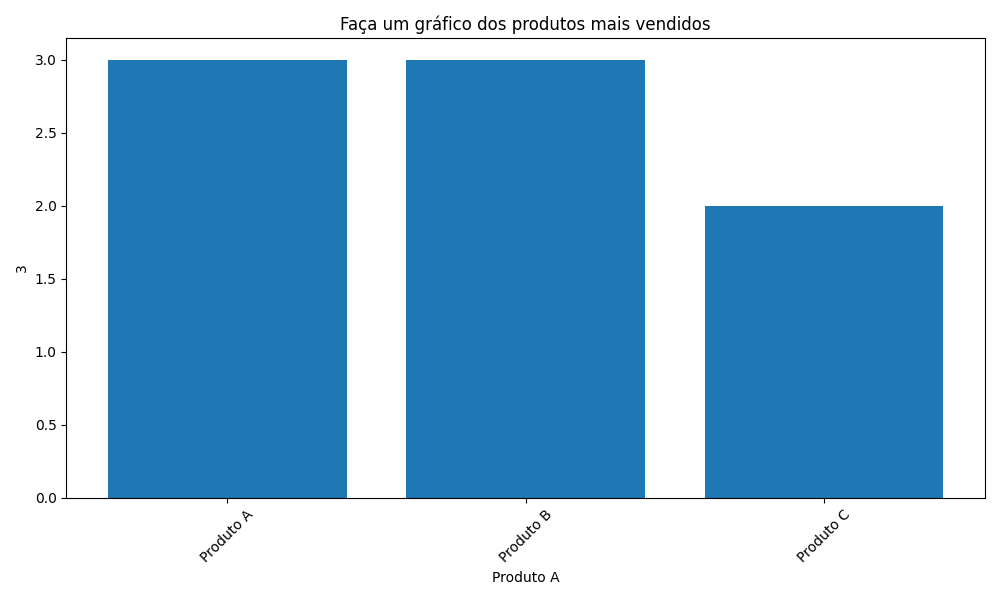

In [29]:
question = "Faça um gráfico dos produtos mais vendidos"
process_question(question)

In [30]:
question = "Faça um gráfico dos produtos mais caros"
process_question(question)

Erro ao executar a consulta SQL: Binder Error: column "valor_pago" must appear in the GROUP BY clause or must be part of an aggregate function.
Either add it to the GROUP BY list, or use "ANY_VALUE(valor_pago)" if the exact value of "valor_pago" is not important.
LINE 1: SELECT produto, valor_pago FROM clientes GROUP BY produ...
                        ^


In [31]:
question = "Qual é o produto mais popular entre os clientes que possuem plano anual?"
process_question(question)


Resultados da consulta:
('Produto A',)

Interpretação dos resultados:
Resultados da Consulta: O produto mais popular entre os clientes que possuem plano anual é o "Produto A".

Resposta à Pergunta Original: Sim, conforme resultado da consulta, o "Produto A" é o mais popular entre os clientes que adquiriram o plano anual.

Tipo de Gráfico Adequado: Ainda que a resposta seja textual, se a consulta contasse apenas com dados numéricos para comparar os produtos, seria preciso visualizar esses dados de forma a facilitar comparação. A recomendação então seria um Gráfico de Pizza sem 'Total' (percentagem sobre o produto mais frequente).

Exemplo:
 * Se a consulta tivesse sido: SELECT produto, count(produto) AS quantidade 
FROM clientes 
WHERE plano  =  'anual' 
GROUP BY produto
ORDER BY quantidade DESC
Imagine o resultado como sendo informação disponível para visualização com os dados comparáveis numéricos; e caso hajam apenas produtos, sugeriríamos essa abordagem para comparar tudo. Contudo,


Resultados da consulta:
('Produto A', 3)
('Produto B', 3)
('Produto C', 2)

Interpretação dos resultados:
**Interpretação dos resultados:**

A consulta SQL gerou três resultados, mostrando os produtos mais vendidos após agrupar os dados pelos produtos e contar a quantidade de clientes que compraram cada um deles. Os resultados são ordenados em ordem decrescente (em ordem de mais vendido para menos vendido).

- O "Produto A" foi o mais vendido, com 3 clientes que compraram esse produto.
- O "Produto B" também foi bem vendido, apesar de alguns produtos ainda estar sendo uma equação. Isso também tem ocorrido a 3 clientes que compraram, na sua vez.
- O "Produto C" foi o menos vendido, com 2 clientes que compraram esse produto.

**Resposta à pergunta original:**

O gráfico dos produtos mais vendidos contém 3 produtos atuais. Dois deles têm a mesma quantidade vendida. Estes são produtos A e B, em igualdade. O outro produto C com uma quantidade muito menor contém menos compras do produto. O 


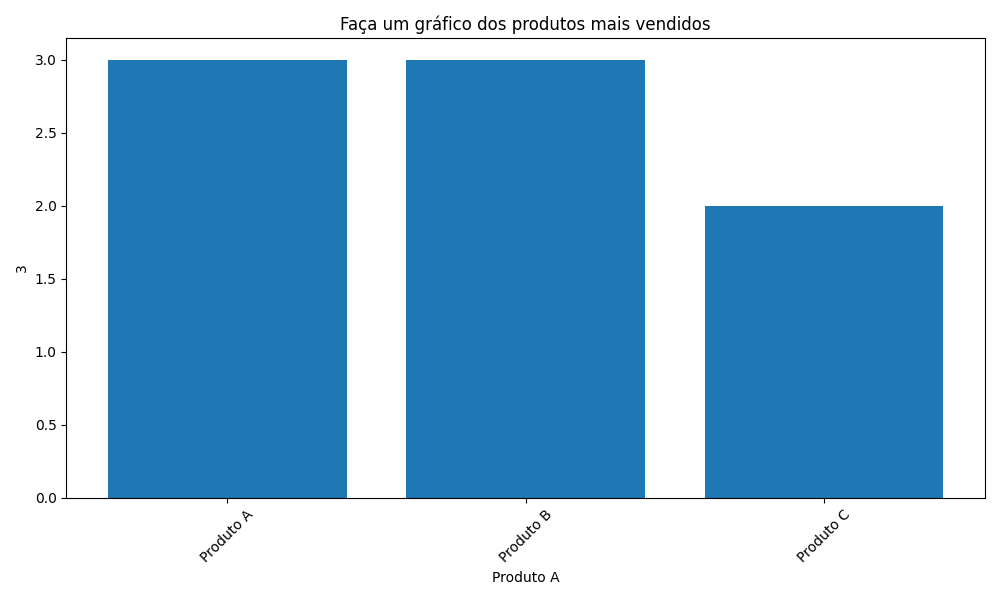

In [33]:
question = "Faça um gráfico dos produtos mais vendidos"
process_question(question)

# Análise do Código Utilizando Groq e Comparação com o Uso do LangGraph

Neste documento, faremos uma análise detalhada do código fornecido, que utiliza a biblioteca **Groq** para interagir com modelos de linguagem. Em seguida, compararemos este código com o anterior, que utiliza **OpenAI** e **LangGraph**, destacando as vantagens e desvantagens de cada abordagem. Também discutiremos as implicações de não utilizar o LangGraph em termos de controle de fluxos de trabalho "agentes" (agentic workflows) e os benefícios de usar software de código aberto.

## Visão Geral do Código

O código fornecido implementa um pipeline para processar perguntas em linguagem natural, gerar consultas SQL correspondentes, executar essas consultas em um banco de dados **DuckDB**, interpretar os resultados e, se aplicável, gerar gráficos para visualização.

### Principais Componentes:

1. **Configuração do Modelo:**
   - Suporta dois tipos de modelos: "groq" e "openai".
   - Utiliza o modelo **llama-3.1-8b-instant** da Groq quando `MODEL_TYPE` é "groq".
   - Possibilidade de utilizar modelos da OpenAI se `MODEL_TYPE` for "openai".

2. **Função `invoke_model`:**
   - Função genérica para invocar o modelo de linguagem apropriado com base no `MODEL_TYPE`.
   - Encapsula a chamada ao modelo, tornando o código flexível para diferentes backends.

3. **Definição do Estado do Agente (`AgentState`):**
   - Utiliza `TypedDict` para definir a estrutura do estado, incluindo campos como `question`, `sql`, `accepted`, etc.

4. **Funções de Processamento:**
   - **`get_database_schema`:** Recupera o esquema do banco de dados DuckDB.
   - **`search_engineer_node`:** Atualiza o estado com o esquema do banco de dados e o caminho do banco de dados.
   - **`senior_sql_writer_node`:** Gera a consulta SQL com base na pergunta do usuário.
   - **`senior_qa_engineer_node`:** Verifica se a consulta SQL atende à pergunta.
   - **`chief_dba_node`:** Fornece feedback para melhorar a consulta SQL se ela for rejeitada.
   - **`interpret_results`:** Interpreta os resultados da consulta e sugere visualizações se aplicável.

5. **Função Principal `process_question`:**
   - Orquestra o fluxo de trabalho, chamando as funções acima em sequência.
   - Implementa um loop para refinar a consulta SQL até ser aceita ou atingir o número máximo de revisões.
   - Executa a consulta no banco de dados e interpreta os resultados.
   - Gera gráficos se necessário.

6. **Exemplo de Uso:**
   - Chama a função `process_question` com uma pergunta específica.

## Análise Detalhada do Código

### Configuração do Modelo

O código permite escolher entre dois tipos de modelos de linguagem:

- **Groq:**
  - Utiliza a API da Groq com uma chave de API específica.
  - Modelo utilizado: `llama-3.1-8b-instant`.
  - A tecnologia LPU (Language Processing Unit) da Groq promete maior velocidade na inferência.

- **OpenAI:**
  - Comentado no código fornecido.
  - Pode ser utilizado configurando a variável `MODEL_TYPE` para "openai".

**Vantagens:**

- **Flexibilidade:** O código é configurável para diferentes backends de modelo de linguagem.
- **Desempenho:** O uso da Groq pode oferecer tempos de resposta mais rápidos devido à tecnologia LPU.

### Função `invoke_model`

Esta função abstrai a chamada ao modelo de linguagem, permitindo que o restante do código seja independente do backend utilizado.

**Importância:**

- **Modularidade:** Facilita a troca de modelos sem alterar o restante do código.
- **Manutenibilidade:** Simplifica a manutenção e atualização do código.

### Definição do Estado do Agente (`AgentState`)

Define a estrutura de dados que mantém o estado ao longo do fluxo de trabalho.

**Campos Importantes:**

- `question`: A pergunta em linguagem natural do usuário.
- `table_schemas`: O esquema do banco de dados.
- `database`: O caminho para o banco de dados DuckDB.
- `sql`: A consulta SQL gerada.
- `reflect`: Lista de feedbacks para melhoria da consulta.
- `accepted`: Flag indicando se a consulta foi aceita.
- `revision`: Contador de revisões da consulta.
- `max_revision`: Número máximo de revisões permitidas.

### Funções de Processamento

#### `get_database_schema`

- Recupera o esquema do banco de dados especificado.
- Utiliza o cursor do DuckDB para obter as tabelas e colunas.

#### `search_engineer_node`

- Atualiza o estado com o esquema do banco de dados e o caminho do banco de dados.
- Prepara o estado para os próximos passos.

#### `senior_sql_writer_node`

- Gera a consulta SQL com base na pergunta do usuário.
- Utiliza o modelo de linguagem para transformar a pergunta em uma consulta SQL válida.
- Segue diretrizes estritas para retornar apenas a consulta SQL sem textos adicionais.

#### `senior_qa_engineer_node`

- Verifica se a consulta SQL atende corretamente à pergunta do usuário.
- Responde com "ACEITO" ou "REJEITADO".

#### `chief_dba_node`

- Fornece feedback detalhado para melhorar a consulta SQL rejeitada.
- Ajuda a refinar a consulta para que atenda aos requisitos.

#### `interpret_results`

- Interpreta os resultados da consulta em linguagem natural.
- Sugere um tipo de gráfico adequado se houver dados numéricos.
- Verifica se há dados numéricos suficientes para gerar um gráfico.
- Gera o gráfico usando Matplotlib e o exibe.

### Função Principal `process_question`

- Inicializa o estado do agente.
- Executa as funções em sequência, implementando um loop para refinamento da consulta SQL.
- Executa a consulta no banco de dados se for aceita.
- Interpreta os resultados e gera gráficos se aplicável.
- Imprime os resultados e a interpretação.

### Exemplo de Uso

- Processa a pergunta: "Qual é a distribuição de produtos entre os clientes que pagam acima da média geral?"
- Demonstra o fluxo completo desde a geração da consulta até a exibição dos resultados.

## Comparação com o Código Utilizando OpenAI e LangGraph

### Uso do LangGraph

**No código anterior:**

- O **LangGraph** foi utilizado para construir um grafo de estados, onde cada nó representa uma função ou tarefa específica.
- Oferece controle detalhado sobre o fluxo de trabalho, permitindo condicionais e loops controlados.
- Utiliza conceitos como `StateGraph`, `START`, `END`, e `conditional_edges` para definir a lógica do fluxo.

**No código atual:**

- Não utiliza o LangGraph.
- O fluxo de trabalho é implementado sequencialmente através de funções chamadas diretamente ou em loops.
- Não há estrutura formal para representar o grafo ou o fluxo de estados.

### Controle de Fluxo

**Com LangGraph:**

- O LangGraph permite definir arestas condicionais, garantindo que o fluxo siga caminhos específicos com base no estado atual.
- Evita loops infinitos estabelecendo limites, como o `max_revision`.
- Facilita a visualização e compreensão do fluxo de trabalho.

**Sem LangGraph:**

- O controle de fluxo é gerenciado manualmente, como no loop `while` na função `process_question`.
- Pode ser mais propenso a erros se não houver cuidado na implementação das condições de parada.
- Menos transparente em termos de visualização do fluxo de estados.

### Vantagens e Desvantagens de Não Utilizar o LangGraph

**Vantagens:**

- **Simplicidade Inicial:** Para códigos menores ou menos complexos, não utilizar o LangGraph pode simplificar a implementação inicial.
- **Menos Dependências:** Reduz a necessidade de importar e aprender uma nova biblioteca.
- **Controle Direto:** O programador tem controle direto sobre a ordem de execução das funções.

**Desvantagens:**

- **Menos Controle sobre o Fluxo de Trabalho:** Sem o LangGraph, é mais difícil gerenciar fluxos complexos com condicionais e loops controlados.
- **Propensão a Erros:** O controle manual do fluxo pode levar a erros como loops infinitos ou condições mal implementadas.
- **Menos Transparência:** A visualização do fluxo de estados não é tão clara, dificultando a manutenção e expansão do código.
- **Escalabilidade Limitada:** Para projetos maiores, a falta de uma estrutura como o LangGraph pode tornar o código difícil de gerenciar.

### Implicações para Workflows Agentes (Agentic Workflows)

- **Menos Modularidade:** Sem o LangGraph, o código é menos modular, dificultando a reutilização de componentes.
- **Menos Flexibilidade:** É mais difícil modificar o fluxo de trabalho ou adicionar novos nós sem reestruturar significativamente o código.
- **Menos Controle:** Não há uma maneira padronizada de controlar o estado e as transições entre estados, o que pode levar a inconsistências.

## Vantagens de Utilizar Software Open Source

- **Transparência:** O código-fonte aberto permite que os desenvolvedores entendam exatamente como as bibliotecas funcionam.
- **Personalização:** É possível modificar o código-fonte para atender a necessidades específicas.
- **Comunidade e Suporte:** Projetos open source geralmente têm comunidades ativas que contribuem com melhorias e oferecem suporte.
- **Custo:** Não há custos de licenciamento, o que é benéfico para indivíduos e organizações com orçamentos limitados.
- **Segurança:** O código aberto pode ser auditado por qualquer pessoa, potencialmente identificando e corrigindo vulnerabilidades mais rapidamente.

## Considerações sobre o Uso do Groq

- **Desempenho:** A tecnologia LPU da Groq promete desempenho superior em termos de velocidade de inferência.
- **Dependência de Terceiros:** O uso de uma API externa como a da Groq introduz dependências que podem afetar a disponibilidade e custos futuros.
- **Flexibilidade do Modelo:** Se os modelos da Groq são proprietários, pode haver limitações em termos de customização ou extensão.
- **Comunidade e Suporte:** Pode ter uma comunidade menor em comparação com projetos open source amplamente adotados.

## Conceitos Importantes Destacados no Código

- **Abstração de Modelos:** A função `invoke_model` abstrai a chamada ao modelo de linguagem, permitindo flexibilidade na escolha do backend.
- **Estado do Agente:** O uso de `TypedDict` para definir o estado promove consistência e legibilidade.
- **Interação com Banco de Dados:** O código demonstra como interagir com o DuckDB para executar consultas e recuperar resultados.
- **Processamento Iterativo:** Implementa um loop para refinar a consulta SQL com base em feedback, mostrando um exemplo de melhoria iterativa.
- **Geração de Gráficos Dinâmicos:** Usa Matplotlib para gerar gráficos com base nos resultados, incluindo a conversão para HTML para exibição.

## Conclusão

O código fornecido implementa um pipeline funcional para converter perguntas em linguagem natural em consultas SQL, executar essas consultas e apresentar os resultados, incluindo visualizações gráficas quando apropriado. No entanto, ao não utilizar o LangGraph, perde-se a estrutura formal para gerenciar o fluxo de trabalho de maneira modular e controlada.

**Vantagens do Código Atual:**

- **Simplicidade:** Pode ser mais fácil de entender para quem não está familiarizado com o LangGraph.
- **Desempenho Potencialmente Melhorado:** O uso da Groq pode oferecer tempos de resposta mais rápidos.

**Desvantagens do Código Atual:**

- **Menos Controle sobre o Fluxo:** Sem o LangGraph, é mais difícil gerenciar fluxos complexos e garantir que o estado seja consistente.
- **Escalabilidade Limitada:** Pode ser mais difícil adicionar novas funcionalidades ou modificar o fluxo de trabalho sem uma estrutura formal.
- **Menos Transparência:** A visualização do fluxo de estados e decisões é menos clara, o que pode dificultar a manutenção.

**Vantagens de Utilizar o LangGraph e OpenAI:**

- **Controle e Modularidade:** O LangGraph permite construir fluxos de trabalho complexos de forma organizada.
- **Facilidade de Manutenção:** A modularidade facilita a identificação e correção de problemas.
- **Escalabilidade:** É mais fácil adicionar novas funcionalidades ou modificar o fluxo de trabalho.
- **Transparência do Fluxo:** O fluxo de estados é claramente definido, facilitando a compreensão do sistema.

**Considerações Finais:**

A escolha entre utilizar uma estrutura como o LangGraph e implementar o fluxo de trabalho manualmente depende das necessidades específicas do projeto. Para projetos simples ou com fluxos lineares, a implementação manual pode ser suficiente. No entanto, para sistemas mais complexos que exigem controle rigoroso do fluxo de trabalho e escalabilidade, utilizar ferramentas como o LangGraph pode oferecer benefícios significativos.

Além disso, optar por soluções open source proporciona maior flexibilidade, transparência e potencial para colaboração com a comunidade, o que pode ser vantajoso a longo prazo.